In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (GridSearchCV, learning_curve,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from transform_data import get_train_test_ds

random_state = 42
mlp_layers = [128, 64, 16]

In [2]:
X, X_train, X_test, y, y_train, y_test = get_train_test_ds('income', 'data/adult.data', random_state)
# X, X_train, X_test, y, y_train, y_test = get_train_test_ds('bank', 'data/bank.csv', random_state)
X_train.shape, X_test.shape

((26048, 58), (6513, 58))

In [3]:
clf = MLPClassifier(
  hidden_layer_sizes=mlp_layers, 
  activation='relu',
  solver='adam',
  learning_rate='adaptive', 
  early_stopping=True, 
  max_iter=128,
  random_state=random_state,
)
pipe = Pipeline([
  ('scaler', StandardScaler()), 
  ('mlp', clf),
])
f1_scorer = make_scorer(f1_score)

In [4]:
param_grid = {'mlp__alpha': [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
              'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [5]:
print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'mlp__alpha': 1, 'mlp__learning_rate_init': 0.001}
Train F1
0.6966680378445085
Test F1
0.6893172165958837


income
```
Best parameters: {'mlp__alpha': 1, 'mlp__learning_rate_init': 0.001}
Train F1
0.6966680378445085
Test F1
0.6893172165958837
```

bank
```
Best parameters: {'mlp__alpha': 1, 'mlp__learning_rate_init': 0.001}
Train F1
0.6161906100082298
Test F1
0.6155957378107846
```

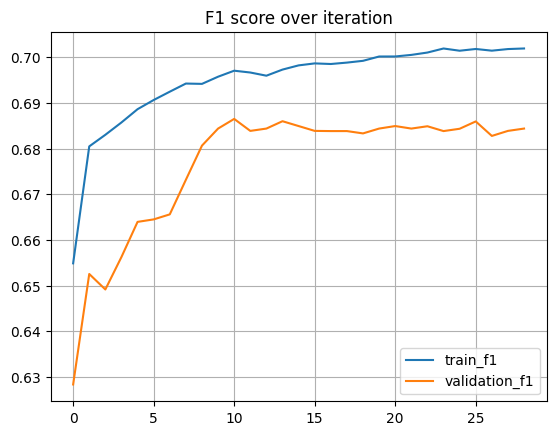

In [6]:
X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state, stratify=y_train)

params = grid_search.best_params_.copy()
params_key = list(params.keys())
for k in params_key:
    params[k.removeprefix('mlp__')] = params.pop(k)

clf = MLPClassifier(
    hidden_layer_sizes=mlp_layers, 
    activation='relu',
    solver='adam',
    learning_rate='adaptive', 
    max_iter=128,
    random_state=random_state,
    **params,
)

scaler = StandardScaler()
X_train_inner = scaler.fit_transform(X_train_inner)
X_valid = scaler.transform(X_valid)

train_f1_list = []
valid_f1_list = []

for i in range(best_model['mlp'].n_iter_):
    clf.partial_fit(X_train_inner, y_train_inner, classes=[0,1])
    pred = clf.predict(X_train_inner)
    train_f1_list.append(f1_score(y_train_inner, pred))

    pred = clf.predict(X_valid)
    valid_f1_list.append(f1_score(y_valid, pred))

plt.plot(train_f1_list, label='train_f1')
plt.plot(valid_f1_list, label='validation_f1')

plt.title(f"F1 score over iteration")
plt.legend()
plt.grid()
plt.show()

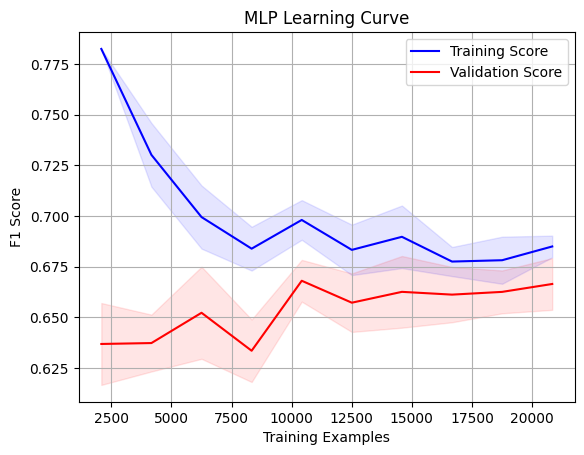

In [7]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('MLP Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

[0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


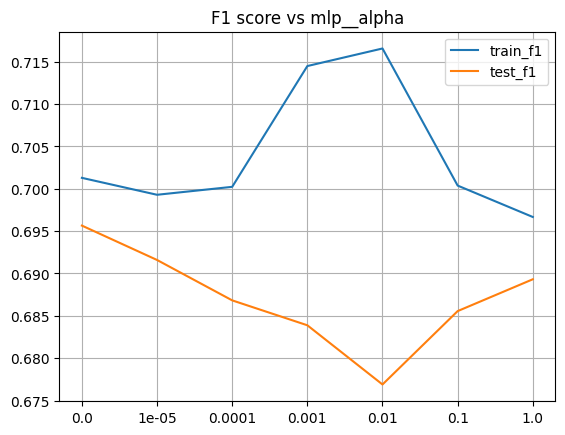

In [8]:
plot_param = 'mlp__alpha'

param_list = param_grid[plot_param]
print(param_list)
train_f1_score_list = []
test_f1_score_list = []

for param in param_list:
    params = grid_search.best_params_.copy()
    params_key = list(params.keys())
    for k in params_key:
        params[k.removeprefix('mlp__')] = params.pop(k)
    params[plot_param.removeprefix('mlp__')] = param

    clf = MLPClassifier(
        hidden_layer_sizes=mlp_layers, 
        activation='relu',
        solver='adam',
        learning_rate='adaptive', 
        early_stopping=True, 
        max_iter=128,
        random_state=random_state,
        **params,
    )
    pipe = Pipeline([
      ('scaler', StandardScaler()), 
      ('mlp', clf),
    ])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    train_f1_score_list.append(f1_score(y_train, y_train_pred))

    y_test_pred = pipe.predict(X_test)
    test_f1_score_list.append(f1_score(y_test, y_test_pred))

plot_df = pd.DataFrame({"train_f1": train_f1_score_list, "test_f1": test_f1_score_list}, index=param_list)
plot_df = plot_df.reset_index()

default_x_ticks = range(plot_df.shape[0])
plt.plot(default_x_ticks, plot_df['train_f1'], label='train_f1')
plt.plot(default_x_ticks, plot_df['test_f1'], label='test_f1')
plt.xticks(default_x_ticks, plot_df['index'])

plt.title(f"F1 score vs {plot_param}")
plt.grid()
plt.legend()
plt.show()

In [9]:
%%time

params = grid_search.best_params_.copy()
params_key = list(params.keys())
for k in params_key:
    params[k.removeprefix('mlp__')] = params.pop(k)
clf = MLPClassifier(
    hidden_layer_sizes=mlp_layers, 
    activation='relu',
    solver='adam',
    learning_rate='adaptive', 
    early_stopping=True, 
    max_iter=128,
    random_state=random_state,
    **params,
)
pipe = Pipeline([
  ('scaler', StandardScaler()), 
  ('mlp', clf),
])
pipe.fit(X_train, y_train)

CPU times: user 19.4 s, sys: 46.5 s, total: 1min 5s
Wall time: 5.85 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=1, early_stopping=True,
                               hidden_layer_sizes=[128, 64, 16],
                               learning_rate='adaptive', max_iter=128,
                               random_state=42))])

In [10]:
%%time

y_test_pred = pipe.predict(X_test)

CPU times: user 40.8 ms, sys: 143 ms, total: 184 ms
Wall time: 17.4 ms
